In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import json
import re


import unidecode #for removing accents from strings.


import os

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords

from nltk.stem.porter import PorterStemmer


# Training the Classifiers

In this notebook, we show how we used the processed Arxiv and Mathscinet data and the Word2Vec embedding to train a title classifier. 

First, we load the Bigram model and Word2Vec models.

In [2]:
bigrammer = gensim.models.phrases.Phrases.load("bigram.model")


#We will also need a generator to convert the processed texts to bigrammed texts.

class get_bigrammed_texts:
    def __init__(self, file_name = "processed_abstracts.csv", 
                 column = "processed_abstract", 
                 bigrammer=bigrammer,
                preprocessed = True):
        
        self.file_name = file_name
        self.column = column
        self.epoch=0
        
        if preprocessed == True:
            self.process = lambda x: bigrammer[x.split(" ")]
        else:
            self.preprocess = lambda x : bigrammer[get_sring_tokens(x)]

    
    def __iter__(self):
        
        self.epoch+=1
        
        i=0
        
        df = pd.read_csv(self.file_name,chunksize=10000)
        
        for chunk in df:
            for token in chunk[self.column]:
                yield self.process(token)
                print(f"\r{i} articles of epoch {self.epoch}...",end="")
                i+=1
                
                

bigram_generator = get_bigrammed_texts()

wv_model = gensim.models.Word2Vec.load("word2vec.model")

# Learning the classifiers using the word2vec embeddings

In this section we'll learn both multiclass and pure/applied classifiers, using either the mathscinet metadata or the arxiv math paper metadata. 

We only need the titles and categories of the papers, which we created earlier. Luckily these files can be fit into memory, so the only preparation of the data we need to do is convert the titles to vectors and do a train/test split. 

In [3]:
#We first define a class that, when instantiated with a given word2vec model and bigrammer, will convert titles
#to vectors by taking the average of the vectors for the words in the title (returning zero for any words that are unknown)

class get_embedding:
    def __init__(self,model,bigrammer):
        self.word2vec = model
        self.bigrammer = bigrammer 
        
        
    def __call__(self,text):
        #Recall that the titles/abstracts are processed and stemmed tokens separated by spaces. 
        #The bigram model takes as input a list of tokens, which we get by splitting the text by spaces. 
        bigrammed_text = bigrammer[text.split(" ")]
        in_vocab = set()
        for word in bigrammed_text:
            if word in self.word2vec.wv.vocab:
                in_vocab.add(word)
        if in_vocab:
            return np.mean([self.word2vec.wv[word] for word in in_vocab], axis=0)
        else:
            return np.zeros(self.word2vec.vector_size)
        
embedding = get_embedding(model=wv_model, bigrammer=bigrammer)

#This returns a list of embedded texts from the specified column in a given dataframe using 
#the supplied bigram and word2vec models



class get_texts_to_vectors:
    def __init__(self,embedding=embedding):
        
        self.embedding = embedding
    
    def __call__(self,df,column):
            
        return np.array([self.embedding(x) for x in df[column]])
    


#Finally, we bring these together into a function that takes a file, splits the file into a train and test
#dataframe, then coverts the specified column to a list of embedded vectors, and returns the train, test dataframes,
#train and test vectors, along with the train and test labels y

#The papers are labeled as 0 for applied and 1 for pure, but depending on what our main goal is we may want to 
#switch their roles, hence the "pure" option if our main goal is to identify pure papers. 


def get_train_test(file_name, column, labels, embedding, split, preprocessed = True,switch=False):
    
    print("Divvying up data...")
    
    texts_to_vecs = get_texts_to_vectors(embedding=embedding)
    
    df = pd.read_csv(file_name)
    
    size_of_df = len(df)
    
    df = df[~df[column].isna()]
    
    print(f"{size_of_df-len(df)} entries had NaNs")
    
    if preprocessed == False:
        
        df["processed_" + column] = df[column].apply(lambda x: " ".join(get_string_tokens(x)))
        
        column = "processed_" + column
    

    assert len(split)==2, "split needs to be a tuple/list giving the validation and test set sizes."
    assert all([x *(1-x)>0 for x in split]), "values in split must be between 0 and 1."
    assert split[0]+split[1]<1, "values in split must add up to less than 1."


    train = df.sample(frac=1-sum(split))

    X_train = texts_to_vecs(train, column)

    val = pd.concat([df,train]).drop_duplicates(keep=False)

    test = val.sample(frac=split[1])

    val = pd.concat([val,test]).drop_duplicates(keep=False)

    if switch==True:
        y_train = 1-train[labels]

        y_val = 1-val[labels]

        y_test = 1-test[labels]
    else:

        y_train = train[labels]

        y_val = val[labels]

        y_test = test[labels]


    X_train = texts_to_vecs(train, column)

    X_val = texts_to_vecs(val, column)

    X_test = texts_to_vecs(test, column)
    
   
    print("Done!")
    
    return {"train_df":train, 
            "X_train":X_train,
            "y_train":y_train,
            "val_df":val,
            "X_val":X_val,
            "y_val":y_val,
            "test_df": test, 
            "X_test":X_test, 
            "y_test":y_test}


    
    
        
        
        

        
        
    
    
    
   


Now we load the dictionaries of datasets we will train on. The two data sets have columns containing the cleaned and processed titles (as per the Cleaning notebook) and a "pure" column with a label of 1 or 0 for pure or applied.

In [13]:
MSN_data = get_train_test("mathscinet.csv", column="processed_title", labels="pure", embedding=embedding, split=(.2,.2), preprocessed =True)


Arxiv_data = get_train_test("processed_titles.csv", column="processed_title", labels="pure", embedding=embedding, split=(.2,.2), preprocessed =True)


Divvying up data...
15 entries had NaNs
Done!
Divvying up data...
73 entries had NaNs
Done!


We also load the arxiv math titles and compare how well our classifiers perform if we just train on math papers.

In [33]:
Arxiv_math_data = get_train_test("processed_math_titles.csv", column="processed_title", labels="pure", embedding=embedding, split=(.2,.2), preprocessed =True)


Divvying up data...
19 entries had NaNs
Done!


# What does the data look like?

We use PCA to visualize the datasets with their labelings. Note that since Arxiv takes articles from many other topics than math, the pure papers make up a small portion, whereas there are more pure papers if we restrict to only math titles. However, we see in any case there is a clear division between pure and applied. Also in the Arxiv_math dataset there seems to be a lot of overlapping points in the projection, which could mean that one of the other principal compents is explaining the divide between pure and applied and hence the pure papers are sitting atop the applied papers. 

/Users/jazzam/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jazzam/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jazzam/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  

Text(0.5, 1.0, 'Arxiv Math Dataset')

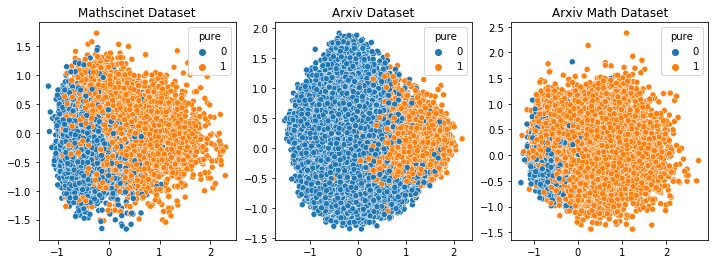

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

MSN_2d = pca.fit_transform(MSN_data["X_test"])
Arxiv_2d = pca.fit_transform(Arxiv_data["X_test"])
Arxiv_math_2d = pca.fit_transform(Arxiv_math_data["X_test"])


fig,ax = plt.subplots(1,3, figsize = (12,4))

sns.scatterplot(MSN_2d[:, 0], MSN_2d[:, 1],
            hue=MSN_data["y_test"], ax=ax[0]).set_title("Mathscinet Dataset")

sns.scatterplot(Arxiv_2d[:, 0], Arxiv_2d[:, 1],
            hue=Arxiv_data["y_test"], ax=ax[1]).set_title("Arxiv Dataset")

sns.scatterplot(Arxiv_math_2d[:, 0], Arxiv_math_2d[:, 1],
            hue=Arxiv_math_data["y_test"], ax=ax[2]).set_title("Arxiv Math Dataset")



In [41]:
print("Percentage of articles that are pure math:")

for name, d in zip(["MSN","Arxiv","Arxiv_math"],[MSN_data,Arxiv_data,Arxiv_math_data]):
    df = d["train_df"]
    print(name + ": ", len(df[df["pure"]==1])/len(df))
    

Percentage of articles that are pure math:
MSN:  0.5857884244827973
Arxiv:  0.17714324088876618
Arxiv_math:  0.8063832678051307


The mathscinet dataset is more balanced between pure and applied, although the skews are not too bad (around 20-80 splits in the Arxiv datasets). 

# Why not logistic regression?

Logistic regression actually performs well already, but we can do a bit better with an extra hidden layer.  In particular, notice the non-linear boundary around the pure papers in the Arxiv dataset above.

Below we show the results for logistic regression using the arxiv and matscinet datasets. The high accuracy for the arxiv model is quite high, but this is because the majority of papers in that set are applied. If we restrict to just the math dataset, the accuracy drops quite a bit.

In [37]:
from sklearn.linear_model import LogisticRegression

LR_MSN = LogisticRegression()
LR_Arxiv = LogisticRegression()
LR_Arxiv_math = LogisticRegression()

LR_MSN.fit(MSN_data["X_train"], MSN_data["y_train"])

LR_Arxiv.fit(Arxiv_data["X_train"], Arxiv_data["y_train"])

LR_Arxiv_math.fit(Arxiv_math_data["X_train"], Arxiv_math_data["y_train"])



data = [MSN_data, Arxiv_data, Arxiv_math_data]
scores = pd.DataFrame( {"MSN Dataset":[LR_MSN.score(d["X_test"],d["y_test"]) for d in data],
                      "Arxiv Dataset":[LR_Arxiv.score(d["X_test"],d["y_test"]) for d in data],
                      "Arxiv Math Dataset":[LR_Arxiv_math.score(d["X_test"],d["y_test"]) for d in data]})

scores.index = ["MSN", "Arxiv", "Arxiv Math"]

scores






/Users/jazzam/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/jazzam/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

,MSN Dataset,Arxiv Dataset,Arxiv Math Dataset
MSN,0.869592,0.775236,0.788532
Arxiv,0.718217,0.941662,0.404790
Arxiv Math,0.881274,0.814447,0.921139


The above suggests that there isn't really any benefit to train a model on the entire arxiv dataset if our plan is to categorize math papers: the Arxiv model performs very well overall on its own dataset, more so than the other models do on their own datasets, but again the pure papers are a much smaller set, so there is less penalty for getting pure math papers labeled incorrectly. When we apply the same model to the MSN and Arxiv_math papers, it does poorly than the other models do. Thus, when we consider our neural network models below, we will only train two: one trained on Mathscinet papers, and the other trained on Arxiv math papers, and then compare the two. 

## Building the models

In this part we will train two different classifiers that predict whether a paper is pure or applied. We will train the same model two different ways, one on the Mathscinet dataset and then on the Arxiv dataset. Recall that this is part of our goal to get an estimate on the number of PhDs in pure math. We want a conservative estimate that doesn't overestimate this number too much (in a sense, our null hypothesis is that there are not too many pure math PhDs). Hence, we we want to minimize the number of truly applied papers in the papers we predict to be pire, or in other words, we want the majority of our articles predicted to be pure to actually be pure, which is the same as high precision. We use an Adam optimizer with learning rate .001 (previous experiments had an oscilalting validation curve which was mullified by a smaller learning rate).



The second classifier will be a multi-category classifier, where we try to classify which mathematical category a paper belongs to (according to the two different classificiation rules that Arxiv and Mathscinet use). For each of these classifiers there are 32 and 61 labels respectively, depending on whether we are training on the mathscinet or arxiv datasets. In addition to measuring the categorical accuracy, we also kept track of whether the true label was in the top 3 predicted categories. 


We will focus on the binary classifiers first and then use them to study the PhD dataset. After that we'll look at multi-category classifiers.

First we make a function that will generate our models according to our specifications

In [20]:
from tensorflow.keras.layers import Input, Dense, Dropout

from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Model

from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping

def top_3(y_1,y_2):
    return tf.keras.metrics.sparse_top_k_categorical_accuracy(y_1,y_2,3)



def get_model(name, layers = 1, 
              shape=256, labels=1, 
              layer_size = 4096, 
              dropout_rate = .5, 
              lr = .0005, 
              callbacks=True, 
              monitor="val_accuracy"):
    
    
    if labels>1:
        
 

        
        
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),
                  top_3]
        activation = "softmax"
        
        
    else:
    
        loss = "BinaryCrossentropy"
        metrics = ["accuracy",
                   tf.keras.metrics.Precision(name="precision"),
                  tf.keras.metrics.Recall(name="recall")]
        activation = "sigmoid"
    
    inputs = Input(shape = (shape,))
    
    x=inputs 
    
    for i in range(layers):
        
        x = Dense(layer_size, activation ="relu")(x)
        
        x = Dropout(dropout_rate)(x)
        
    x = Dense(labels,activation = activation)(x)
    
    model = Model(name=name, inputs = inputs, outputs = x)
    
    adam = tf.keras.optimizers.Adam(
                learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
                name='Adam')
    
    model.compile(optimizer = adam, metrics = metrics, loss = loss)
    
    model.summary()
    
    if callbacks == True:
        if labels == 1:
        
            callbacks = [CSVLogger(f"models/{name}_history.csv", append=False),
                         ModelCheckpoint(f"models/{name}_model.h5", monitor=monitor, save_best_only=True),
                        EarlyStopping(monitor=monitor, min_delta=0.001, patience=5)]
        else:
        
            callbacks = [CSVLogger(f"models/{name}_history.csv", append=False),
                         ModelCheckpoint(f"models/{name}_model.h5", monitor=monitor, save_best_only=True),
                        EarlyStopping(monitor=monitor, min_delta=0.001, patience=5)]
            
        return model, callbacks
    
    else:
        
        return model





## Training the Binary Classifiers

Now we train the models, each on 15 epochs and batchsize 100. First the Binary Mathscinet Model.

In [21]:
#Binary Mathscinet Model

epochs = 15

model, callbacks = get_model("MSN", layers=1,layer_size=4096)

MSN_history = model.fit(MSN_data["X_train"],MSN_data["y_train"],
                                   epochs = epochs, 
                                   batch_size = 100, 
                                   callbacks = callbacks,
                                  validation_data = (MSN_data["X_val"],MSN_data["y_val"]))


Model: "MSN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              1052672   
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4097      
Total params: 1,056,769
Trainable params: 1,056,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2403/2403 [==============================] - 34s 14ms/step - loss: 0.3035 - accuracy: 0.8717 - precision: 0.8846 - recall: 0.8981 - val_loss: 0.2753 - val_accuracy: 0.8866 - val_precision: 0.9012 - val_recall: 0.9062
Epoch 2/15
2403/2403 [=

Next, we train the Binary Arxiv model.

In [45]:
#Binary Arxiv Model just on math articles

model, callbacks = get_model("Arxiv")

Arxiv_math_history = model.fit(Arxiv_math_data["X_train"],Arxiv_math_data["y_train"],
                                   epochs = epochs, 
                                   batch_size = 100, 
                                   callbacks = callbacks,
                                  validation_data = (Arxiv_math_data["X_val"],Arxiv_math_data["y_val"]))

Model: "Arxiv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_16 (Dense)             (None, 4096)              1052672   
_________________________________________________________________
dropout_8 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 4097      
Total params: 1,056,769
Trainable params: 1,056,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2356/2356 [==============================] - 28s 12ms/step - loss: 0.1904 - accuracy: 0.9235 - precision: 0.9437 - recall: 0.9626 - val_loss: 0.1858 - val_accuracy: 0.9244 - val_precision: 0.9334 - val_recall: 0.9757
Epoch 2/15
2356/2356 

# Results



Depending on your objective, you may be concerned with different metrics of performance. My initial objective was that I wanted to estimate the number of PhDs in pure math (according to my definition of pure math), and in particular I wanted a lower bound (that is, I wanted conservative estimates), hence I wanted to monitor how well the precision was (i.e. the proportion of papers labeled as pure that are actually pure).


In [48]:
histories = {m:pd.read_csv(f"models/{m}_history.csv" ) for m in {"MSN","Arxiv"}}


Text(0.5, 1.0, 'Arxiv model loss, accuracy, and precision')

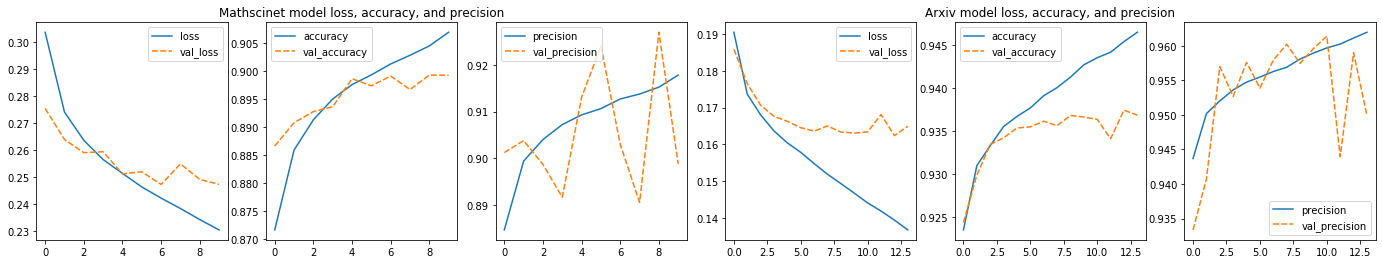

In [49]:

fig, ax = plt.subplots(1,6, figsize = (24,4))

sns.lineplot(data=histories["MSN"][["loss","val_loss"]], ax=ax[0])
sns.lineplot(data=histories["MSN"][["accuracy","val_accuracy"]], ax=ax[1])
sns.lineplot(data=histories["MSN"][["precision","val_precision"]], ax=ax[2])
sns.lineplot(data=histories["Arxiv"][["loss","val_loss"]], ax=ax[3])
sns.lineplot(data=histories["Arxiv"][["accuracy","val_accuracy"]], ax=ax[4])
sns.lineplot(data=histories["Arxiv"][["precision","val_precision"]], ax=ax[5])

ax[1].set_title("Mathscinet model loss, accuracy, and precision")
ax[4].set_title("Arxiv model loss, accuracy, and precision")




The validation curves flatten out after about 5 epochs, after which point the model starts overfitting, however, both models achieve good accuracy on their validation sets (+90% for the MSN model, and 93% in the Arxiv model).

The precision looks less stable, particularly in the Arxiv model, but keep in mind the graphs are scaled to a small rang. The arxiv model seems to have better performace on precision overall (however 80% of articles in the training set are pure).

Note that the two models have the same model structure but are trained on two different datasets with two rules for labelings (due to the different categories that mathscinet and arxiv assign to articles), so it would be useful to know how the model trained on one set performs on the other. For this, we'll compare confusion matrices.

In [50]:


MSN_model = tf.keras.models.load_model('models/MSN_model.h5')
Arxiv_model = tf.keras.models.load_model('models/Arxiv_model.h5')

models = [MSN_model,Arxiv_model]



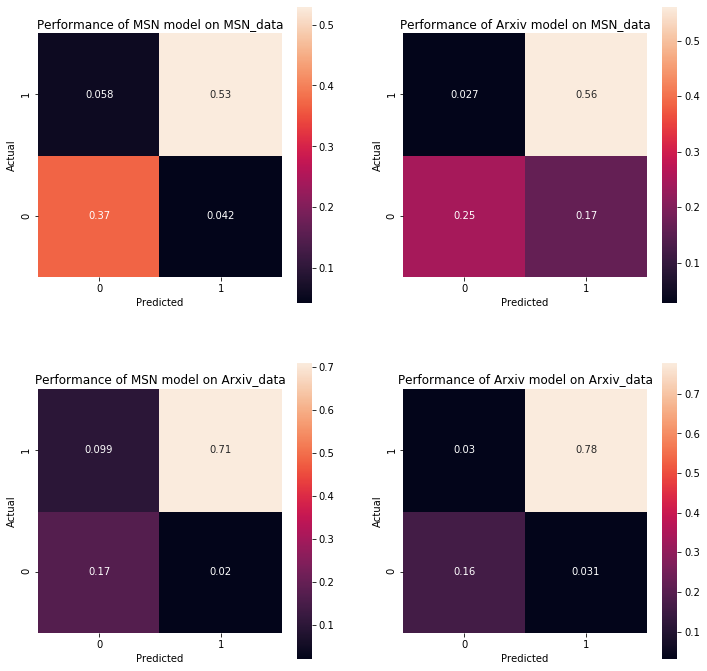

In [99]:


import sklearn

def plot_confusion_matrices(models,data):
    n = len(models)
    m = len(data)
    fig, ax = plt.subplots(m,n, figsize = (6*n,6*m))
    for j, triple in enumerate(data):
        name, X , y_true = triple 
       
        for i, model in enumerate(models):
            if m==1 and n==1:
                a=ax
            elif m>1 and n>1:
                a=ax[j,i]
            else:
                a=ax[i]
            
            
            y_pred = pd.Series(np.rint(model.predict(X).flatten()))
            confusion_matrix = sklearn.metrics.confusion_matrix(y_true,y_pred, normalize="all")

            sns.heatmap(confusion_matrix, annot=True, ax=a)
            a.set_ylabel('Actual')
            a.set_xlabel('Predicted')
            a.set_ylim([0,2])
            a.set_title(f"Performance of {model.name} model on {name}")
            a.set_aspect("equal")
    plt.show()


    
# MSN_model = tf.keras.models.load_model('models/MSN_model.h5')

plot_confusion_matrices(models=models,
                        data=[("MSN_data", MSN_data["X_test"],MSN_data["y_test"]),
                         ("Arxiv_data",Arxiv_math_data["X_test"],Arxiv_math_data["y_test"])])




The arxiv model performs better on arxiv test data vs mathscinet test data (94% on Arxiv data vs 81% on MSN data), whereas the mathscinet model performs about equally well on both data sets (88% on Arxiv vs 90% on MSN). 

The precision of the Arxiv model on the mathscinet data is $.56/(.56 + .17) = .76$, and the mathscinet model on the arxiv set is $.71/(.72+.02) = .96$. 

Given the analysis of the accuracy and precision on the validation sets and also how well the models performed on both datasets, it seems the mathscinet model is more reliable, so we use that to make our final classifier program. 


We combine the preprocessing, embedding, and prediction in one module called "pure_applied" with a method called "predict" that returns 1 for pure and 0 for applied. (Takes a minute to load...)

In [192]:
import pure_applied

#Applied Math paper

pure_applied.predict("Modeling the competitive diffusions of rumor and knowledge and the impacts on epidemic spreading") 

0.0

In [193]:
#Algebra paper

pure_applied.predict("The index of reducibility of parameter ideals in low dimension") 


1.0

There is also an option for returning the probability that the given title is pure.

In [194]:
#Algebra paper

pure_applied.predict("The index of reducibility of parameter ideals in low dimension", prob=True) 


0.93338096

In [195]:

#Probability Paper (again, recall that we are classifying probability as an "applied" subject)

pure_applied.predict("Model reduction of large linear systems via", prob=True)

0.128203

In [196]:
#Differential Geometry

pure_applied.predict("Basmajian-type inequalities for maximal representations")

1.0

In [197]:
#Math Finance

pure_applied.predict("Explicit RKF-Compact Scheme for Pricing Regime Switching American Options with Varying Time Step")


0.0

In [198]:
# Number Theory

pure_applied.predict("Sums of higher divisor functions")

1.0

There are some hairy areas. For example, since graph theory as large overlap with computer science, the predictor is more uncertain on these titles.

In [199]:
#Graph Theory

pure_applied.predict("On supersaturation and stability for generalized Turán problems", prob=True)

0.6789659

In [200]:
#Mathematical Physics

pure_applied.predict("A new physical-space approach to decay for the wave equation with applications to black hole spacetimes", prob=True)

0.9945841

In [201]:
#Numerical analysis

pure_applied.predict("Domain decomposition preconditioners for high-order discretizations of the heterogeneous Helmholtz equation",
                    prob=True)

0.0012204945

In [202]:
pure_applied.predict("Uniform domains")

1.0

Of course, the model is still only 90% accurate. There is definitely confusion in dynamical systems, where there are many pure and applied results and mixes the two up:

In [203]:
#An applied paper in dynamical systems classified as pure

pure_applied.predict("Capturing the cascade: a transseries approach to delayed bifurcations",prob=True)

0.9227589

In [204]:
#A pure paper in dynamical systems classified as applied

pure_applied.predict("Random walks on homogeneous spaces and diophantine approximation on fractals", prob=True)

0.4830526

In [205]:
#The classifier seems to be boarderline about this title. 

#However, it returns to pure if we remove "random walks"

pure_applied.predict("Homogeneous spaces and diophantine approximation on fractals", prob=True)

0.99052894

# Conclusion

The motivation for this project was primarily to get my head around certain ML techniques (i.e. gensim and tensorflow) but with a concrete objective in mind (for me it was estimating numbers of pure math PhDs in a separate project), so I didn't want to put too much time into perfecting this. Hence there are some ways one could try to improve on this project. 

I didn't use TF-IDF representations of the titles since, firstly, its a bit nicer to work with embedded vectors in a small dimensional space, but also I didn't want any one word to have total influence on the prediction, but rather some form of average of the vectors to take into account the context. For example, just because "fractals" are mostly mentioned in pure math shouldn't mean that "neural networks and classifying pictures of fractals" should be classified as pure. Similarly, because "differential equations" is a popular term does not mean its influence on the title should be diminished in comparison to other words in the title. However, a future project could be to try out such a representation. 

There is also the labeling of articles, as explained in the other notebook on Cleaning. There could be more experimenting on how to best clean the data (lemmatization vs stemming, or neither at all, a better filter for getting  rid of LaTeX since there were still some bits missed).











